In [35]:
import datasets
from sentence_transformers import SentenceTransformer
from functools import partial
import torch
import torch.nn.functional as F
import numpy as np
import os
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [36]:
model = SentenceTransformer("/home/teven/tetraencoder/exported_outputs/small_bs_runs/all_datasets_bs192_hardneg/")

In [37]:
candidate_folders = list_subfolders_with_paths = [f.path for f in os.scandir("raw_data/en_submissions_rdf2text") if f.is_dir()]

In [38]:
human_scores = json.load(open("raw_data/english_humeval_data_all_teams.json"))

In [39]:
teams = set([item["submission_id"] for item in human_scores])
human_scores_per_team = {team: [] for team in teams}
for item in human_scores:
    human_scores_per_team[item["submission_id"]].append(item)

In [40]:
def pair_sims(model: SentenceTransformer, texts, rdfs, batch_size: int = 32):
    device = f"cuda"
    model = model.to(device)
    embeddings1 = torch.stack(
        model.encode(texts, show_progress_bar=False, convert_to_numpy=False, batch_size=batch_size, device=device))
    embeddings2 = torch.stack(
        model.encode(rdfs, show_progress_bar=False, convert_to_numpy=False, batch_size=batch_size, device=device))

    cos_sims = F.cosine_similarity(embeddings1, embeddings2).detach().cpu().numpy()

    return cos_sims

In [41]:
# the last line is inconsistent, let's just fix this
rdfs = open(os.path.join("raw_data", "unwrapped_rdfs.txt")).readlines()[:1779]

correctnesses = []
data_coverages = []
fluencies = []
relevances = []
text_structure = []
sim_scores = []

bert_Ps = []
bert_Rs = []
bert_F1s = []
bleurts = []
bleus = []
chrfs = []
ters = []

for candidate_folder in tqdm(candidate_folders):
    
    all_auto_scores = json.load(open(os.path.join(candidate_folder, "primary.en_results")))
    all_bleurt_scores = json.load(open(os.path.join(candidate_folder, "primary.en_results_bleurt")))
    all_hypotheses = open(os.path.join(candidate_folder, "primary.en")).readlines()[:1779]
    all_sim_scores = pair_sims(model, all_hypotheses, rdfs)

    team = candidate_folder.split("/")[-1]
    for item in human_scores_per_team[team]:
        sample_id = int(item["sample_id"]) - 1
        # human judgment
        correctnesses.append(item["Correctness"])
        data_coverages.append(item["DataCoverage"])
        fluencies.append(item["Fluency"])
        relevances.append(item["Relevance"])
        text_structure.append(item["TextStructure"])
        # our score
        sim_scores.append(all_sim_scores[sample_id])
        # automatic scores
        bert_Ps.append(all_auto_scores["bert_precision"][sample_id])
        bert_Rs.append(all_auto_scores["bert_recall"][sample_id])
        bert_F1s.append(all_auto_scores["bert_f1"][sample_id])
        bleurts.append(all_bleurt_scores["bleurt"][sample_id])
        bleus.append(all_auto_scores["bleu_nltk"][sample_id])
        chrfs.append(all_auto_scores["chrf++"][sample_id])
        ters.append(all_auto_scores["ter"][sample_id])

  6%|▋         | 1/16 [00:05<01:28,  5.93s/it]

NILC


 12%|█▎        | 2/16 [00:11<01:19,  5.68s/it]

ORANGE-NLG


 19%|█▉        | 3/16 [00:16<01:10,  5.43s/it]

bt5


 25%|██▌       | 4/16 [00:21<01:05,  5.43s/it]

Baseline-FORGE2020


 31%|███▏      | 5/16 [00:27<00:58,  5.33s/it]

CycleGT


 38%|███▊      | 6/16 [00:32<00:54,  5.41s/it]

DANGNT-SGU


 44%|████▍     | 7/16 [00:38<00:49,  5.45s/it]

TGen


 50%|█████     | 8/16 [00:43<00:42,  5.34s/it]

OSU_Neural_NLG


 56%|█████▋    | 9/16 [00:49<00:38,  5.51s/it]

RALI


 62%|██████▎   | 10/16 [00:54<00:32,  5.49s/it]

FBConvAI


 69%|██████▉   | 11/16 [01:00<00:27,  5.47s/it]

NUIG-DSI


 75%|███████▌  | 12/16 [01:04<00:21,  5.26s/it]

Amazon_AI_Shanghai


 81%|████████▏ | 13/16 [01:10<00:15,  5.22s/it]

Baseline-FORGE2017


 88%|████████▊ | 14/16 [01:14<00:10,  5.12s/it]

cuni-ufal


 94%|█████████▍| 15/16 [01:19<00:05,  5.05s/it]

UPC-POE


100%|██████████| 16/16 [01:24<00:00,  5.30s/it]

Huawei_Noahs_Ark_Lab


In [42]:
print(all_sim_scores)

[0.9463755  0.9587318  0.95154196 ... 0.9515317  0.9272212  0.9558138 ]


In [43]:
correlations = np.corrcoef(np.stack([correctnesses, data_coverages, fluencies, relevances, text_structure, sim_scores, bert_Ps,
                      bert_Rs, bert_F1s, bleurts, bleus, chrfs, ters]))

In [44]:
ticks = ["correctness", "data coverage", "relevance", "fluency", "text structure", "similarity", "bert precision",
        "bert recall", "bert F1", "bleurt", "bleu", "chrf++", "ter"]

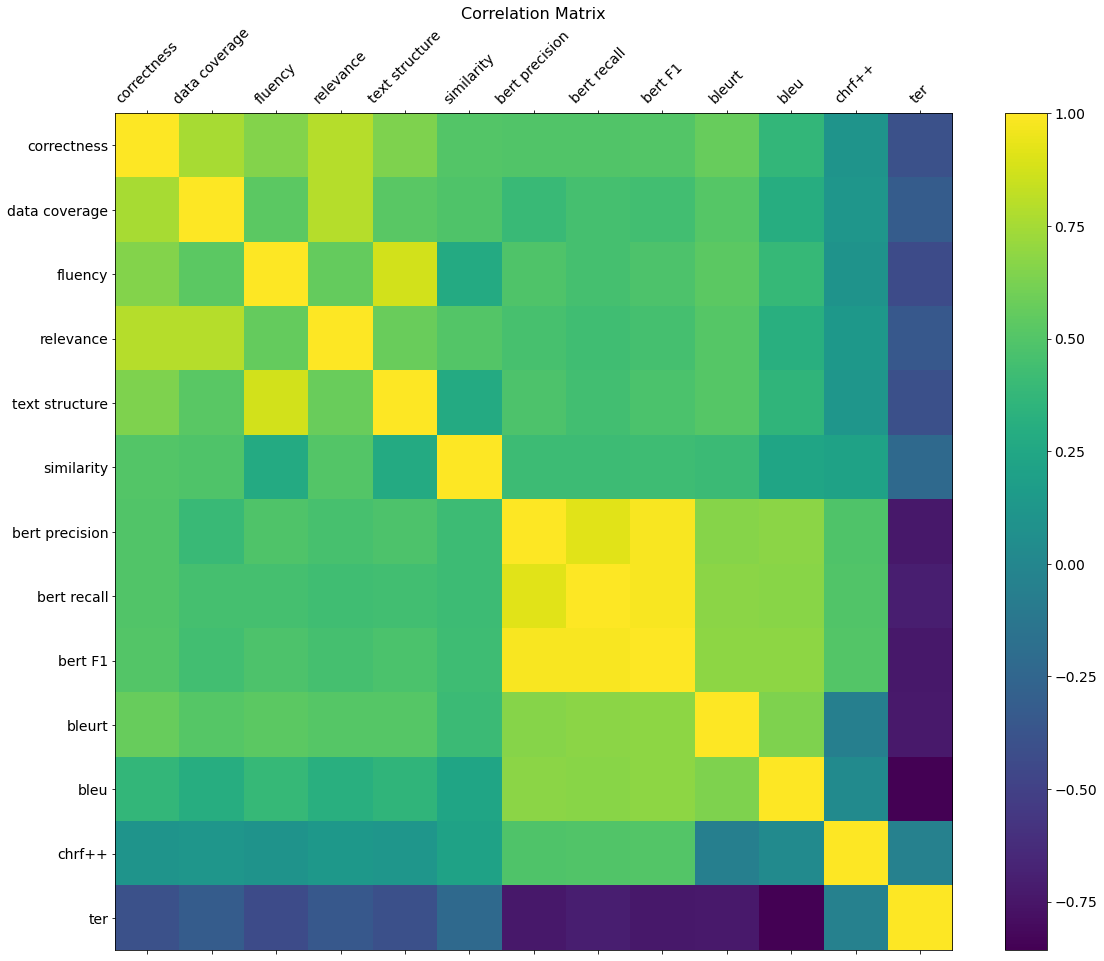

In [46]:
f = plt.figure(figsize=(19, 15))
plt.matshow(correlations, fignum=f.number)
plt.xticks(range(len(ticks)), ticks, fontsize=14, rotation=45)
plt.yticks(range(len(ticks)), ticks, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

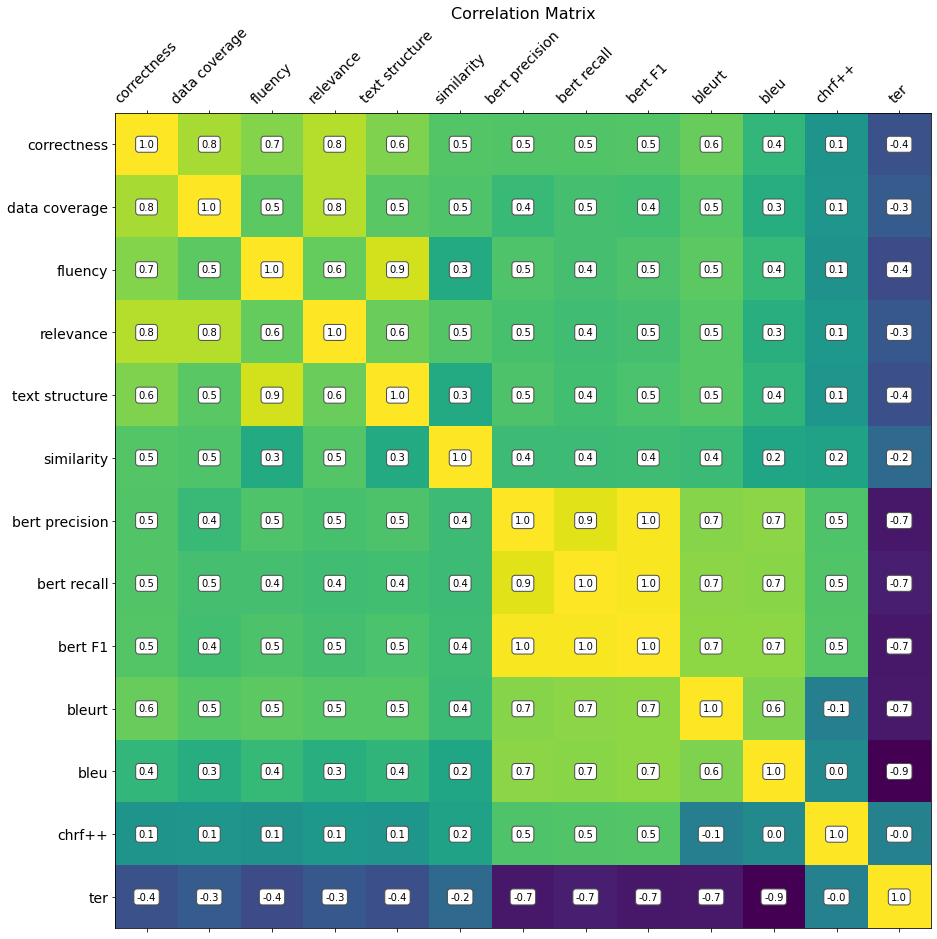

In [47]:
f = plt.figure(figsize=(19, 15))
ax = plt.axes()
ax.matshow(correlations)
for (i, j), z in np.ndenumerate(correlations):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
plt.xticks(range(len(ticks)), ticks, fontsize=14, rotation=45)
plt.yticks(range(len(ticks)), ticks, fontsize=14)
# cb = plt.colorbar()
# cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

In [48]:
sim_scores

[0.70672274,
 0.97364867,
 0.91134757,
 0.8607881,
 0.88927376,
 0.7650989,
 0.8175748,
 0.9174887,
 0.89930636,
 0.81502926,
 0.90995276,
 0.9517719,
 0.9135925,
 0.89955664,
 0.94597775,
 0.9003089,
 0.93801343,
 0.87366164,
 0.81411016,
 0.6314276,
 0.8774497,
 0.6798168,
 0.74794644,
 0.9133078,
 0.92491126,
 0.73227453,
 0.9366819,
 0.8568502,
 0.92436314,
 0.9209525,
 0.92598075,
 0.931898,
 0.624422,
 0.7952114,
 0.9129411,
 0.93839544,
 0.21392545,
 0.9165499,
 0.91087425,
 0.5690948,
 0.83164245,
 0.938264,
 0.69274753,
 0.9345627,
 0.92240125,
 0.8799024,
 0.7415776,
 0.7749817,
 0.91681325,
 0.9375247,
 0.7903382,
 0.9358249,
 0.5895387,
 0.6878508,
 0.9020736,
 0.83833,
 0.70361346,
 0.8408315,
 0.91824305,
 0.6542041,
 0.81643426,
 0.715909,
 0.9175514,
 0.7483939,
 0.76044333,
 0.90193444,
 0.9092299,
 0.95297986,
 0.93870866,
 0.93663865,
 0.8400382,
 0.92989194,
 0.88952386,
 0.66552275,
 0.9515521,
 0.8753093,
 0.93787044,
 0.9333259,
 0.83732134,
 0.8984946,
 0.806686

In [49]:
np.mean(sim_scores)

0.90248686

In [50]:
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 384, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
)

In [51]:
batch_size = 32
device = "cuda"
embeddings1 = torch.stack(
    model.encode(["Agremiação Sportiva Arapiraquense, whose nickname is Alvinegro, play in the Campeonato Brasileiro Série C league in Brazil. Their ground is Estádio Municipal Coaracy da Mata Fonseca in Arapiraca."], show_progress_bar=False, convert_to_numpy=False, batch_size=batch_size, device=device))
embeddings2 = torch.stack(
    model.encode([' [S] Estádio_Municipal_Coaracy_da_Mata_F'
                  'onseca [P] location [O] Arapiraca [S] Agremiação_Sportiva_Arapiraquense [P] league [O] Campeonato_Brasileiro_Série_C [S] Campeonato_Brasileiro_Série_C [P] country [O] Brazil [S] Agremiação_Sportiva_Arapiraquense [P] nickname [O] "''Alvinegro" [S] Agremiação_Sportiva_Arapiraquense [P] ground [O] Estádio_Municipal_Coaracy_da_Mata_Fonseca'], show_progress_bar=False, convert_to_numpy=False, batch_size=batch_size, device=device))

cos_sims = F.cosine_similarity(embeddings1, embeddings2).detach().cpu().numpy()
print(cos_sims)

[0.945624]
